In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import numpy as np
import random
import torchvision
import torchvision.transforms as transforms

import os
import matplotlib.pyplot as plt
from torchsummary import summary

from resnet import ResNet18  # Import baseline ResNet-18 model

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
from torch.optim.lr_scheduler import OneCycleLR


torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Custom MixUp function
def mixup(data, targets, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = data.size()[0]
    index = torch.randperm(batch_size).to(data.device)

    mixed_data = lam * data + (1 - lam) * data[index, :]
    targets_a, targets_b = targets, targets[index]
    
    return mixed_data, targets_a, targets_b, lam

# Custom CutMix function
def cutmix(data, targets, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = data.size()[0]
    index = torch.randperm(batch_size).to(data.device)

    W, H = data.size()[2], data.size()[3]
    cx, cy = np.random.randint(W), np.random.randint(H)
    cut_w, cut_h = W // 2, H // 2

    x1, x2 = np.clip(cx - cut_w // 2, 0, W), np.clip(cx + cut_w // 2, 0, W)
    y1, y2 = np.clip(cy - cut_h // 2, 0, H), np.clip(cy + cut_h // 2, 0, H)

    data[:, :, x1:x2, y1:y2] = data[index, :, x1:x2, y1:y2]

    targets_a, targets_b = targets, targets[index]
    
    return data, targets_a, targets_b, lam

# Corrected transform_train pipeline
transform_train = transforms.Compose([
    transforms.AutoAugment(transforms.autoaugment.AutoAugmentPolicy.CIFAR10),  # Apply AutoAugment first (expects PIL image)
    transforms.RandomCrop(32, padding=4),  # Cropping should also be before ToTensor
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),  # Convert to tensor AFTER all PIL-based transformations
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Can be applied to tensors
    transforms.RandomErasing(p=0.5),  # Can be applied to tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # Apply normalization last
])


# Transform Pipeline for Test Data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # Normalization
])

# Load Dataset with New Augmentations
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)


# Initialize Baseline Model
print('==> Building ResNet-18 Baseline Model..')
net = ResNet18().to(device)
summary(net, (3, 32, 32))  # Display parameter count

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(trainloader), epochs=150)

==> Building ResNet-18 Baseline Model..
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728

In [4]:

# Training & Evaluation Functions
def train(epoch, use_mixup=True, use_cutmix=True):
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        # Apply MixUp or CutMix probabilistically
        if use_mixup and random.random() > 0.5:
            inputs, targets_a, targets_b, lam = mixup(inputs, targets)
            outputs = net(inputs)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        elif use_cutmix and random.random() > 0.5:
            inputs, targets_a, targets_b, lam = cutmix(inputs, targets)
            outputs = net(inputs)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        else:
            outputs = net(inputs)
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    print(f'Train Epoch {epoch}: Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f}%')
    return train_loss / (batch_idx+1), 100.*correct/total


def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    acc = 100.*correct/total
    print(f'Test Epoch {epoch}: Loss: {test_loss/(batch_idx+1):.3f} | Acc: {acc:.3f}%')
    return test_loss / (batch_idx+1), acc


In [5]:

# Training Loop with Logging
num_epochs = 150
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(epoch)
    test_loss, test_acc = test(epoch)
    scheduler.step()
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)


Train Epoch 0: Loss: 2.182 | Acc: 19.720%
Test Epoch 0: Loss: 1.652 | Acc: 44.420%
Train Epoch 1: Loss: 2.043 | Acc: 26.448%
Test Epoch 1: Loss: 1.414 | Acc: 49.480%
Train Epoch 2: Loss: 1.977 | Acc: 29.642%
Test Epoch 2: Loss: 1.288 | Acc: 54.690%
Train Epoch 3: Loss: 1.909 | Acc: 33.386%
Test Epoch 3: Loss: 1.278 | Acc: 54.480%
Train Epoch 4: Loss: 1.858 | Acc: 35.852%
Test Epoch 4: Loss: 1.170 | Acc: 58.560%
Train Epoch 5: Loss: 1.807 | Acc: 37.084%
Test Epoch 5: Loss: 1.015 | Acc: 65.000%
Train Epoch 6: Loss: 1.784 | Acc: 39.062%
Test Epoch 6: Loss: 0.916 | Acc: 68.940%
Train Epoch 7: Loss: 1.751 | Acc: 41.450%
Test Epoch 7: Loss: 0.939 | Acc: 70.110%
Train Epoch 8: Loss: 1.731 | Acc: 40.822%
Test Epoch 8: Loss: 1.026 | Acc: 67.910%
Train Epoch 9: Loss: 1.723 | Acc: 41.884%
Test Epoch 9: Loss: 0.815 | Acc: 73.690%
Train Epoch 10: Loss: 1.720 | Acc: 41.844%
Test Epoch 10: Loss: 0.802 | Acc: 75.120%
Train Epoch 11: Loss: 1.677 | Acc: 43.296%
Test Epoch 11: Loss: 0.853 | Acc: 72.400%


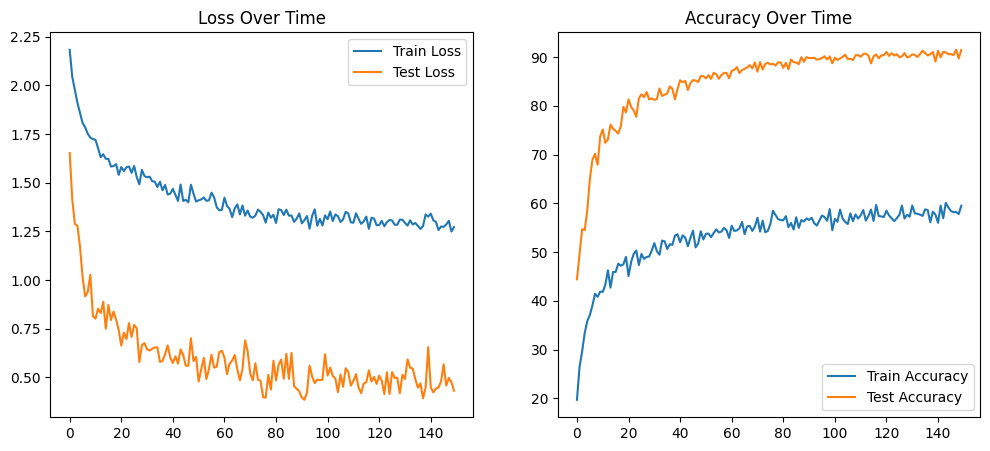

In [6]:

# Plot Training Progress
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Over Time')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Accuracy Over Time')
plt.legend()
plt.show()


In [7]:
from collections import Counter
predicted_classes = []
for inputs, _ in testloader:
    inputs = inputs.to(device)
    outputs = net(inputs)
    _, predicted = outputs.max(1)
    predicted_classes.extend(predicted.cpu().numpy())

print(Counter(predicted_classes))


Counter({np.int64(5): 1047, np.int64(1): 1037, np.int64(6): 1034, np.int64(2): 1030, np.int64(4): 1015, np.int64(7): 1008, np.int64(0): 983, np.int64(8): 970, np.int64(9): 967, np.int64(3): 909})


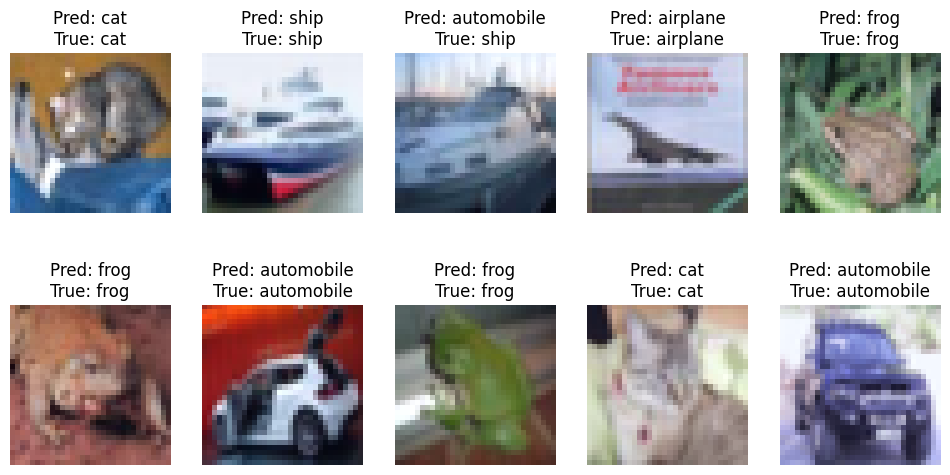

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# CIFAR-10 class labels
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Get some test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Predict
net.eval()
outputs = net(images.to(device))
_, predicted = outputs.max(1)

# Display
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to image
    ax.imshow((img * 0.2 + 0.5).clip(0, 1))  # Unnormalize
    ax.set_title(f"Pred: {classes[predicted[i]]}\nTrue: {classes[labels[i]]}")
    ax.axis('off')

plt.show()


In [9]:
model_path = "cifar10_resnet18.pth"

# If using DataParallel, remove the module wrapper before saving
if isinstance(net, torch.nn.DataParallel):
    torch.save(net.module.state_dict(), model_path)  # Save model without "module" prefix
else:
    torch.save(net.state_dict(), model_path)  # Save normally

print(f"Model saved to {model_path}")


Model saved to cifar10_resnet18.pth


In [10]:
# Load the saved model
net = ResNet18().to(device)
net.load_state_dict(torch.load(model_path))
net.eval()  # Set the model to evaluation mode
print("Model loaded successfully.")

# Run test evaluation
test_loss, test_acc = test(num_epochs)  # Running test on the loaded model


Model loaded successfully.
Test Epoch 150: Loss: 0.432 | Acc: 91.410%


In [ ]:
import pandas as pd
import numpy as np

# Prepare for inference
predictions = []

net.eval()  # Ensure model is in evaluation mode
with torch.no_grad():
    for batch_idx, (inputs, _) in enumerate(testloader):  # Ignore labels
        inputs = inputs.to(device)
        outputs = net(inputs)
        _, predicted = outputs.max(1)  # Get predicted class

        # Store predictions
        predictions.extend(predicted.cpu().numpy())

# Create a Kaggle submission CSV
# submission_df = pd.DataFrame({"ID": np.arange(len(predictions)), "Label": predictions})
# submission_df.to_csv("submission.csv", index=False)



submission_df = pd.DataFrame({"ID": np.arange(len(predictions)), "Label": [classes[p] for p in predictions]})
submission_df.to_csv("submission.csv", index=False)

print("Submission file saved as submission.csv")

Submission file saved as submission.csv


In [13]:
# Read the test file, note that it has no labels and needs to be used with your model inference to predict outputs.
import pickle

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# Load the batch
cifar10_batch = load_cifar_batch('cifar_test_nolabel.pkl')

# Extract images 
images = cifar10_batch[b'data']
# Unlike the train images you are not required to reshape to (number of images, width, height, channels) 
# as the test data is already in (N x W x H x C) format

Submission file saved as submission.csv


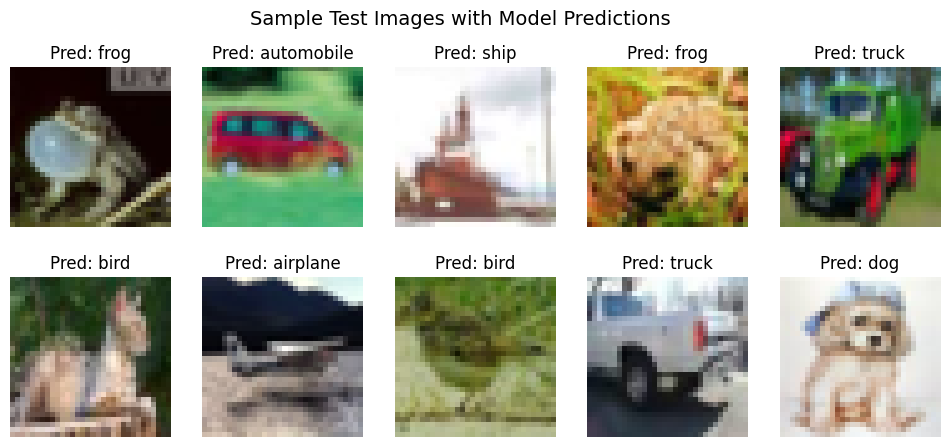

In [15]:
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the Kaggle test dataset
def load_cifar_batch(file):
    with open(file, "rb") as fo:
        batch = pickle.load(fo, encoding="bytes")
    return batch

# Load the batch
cifar10_batch = load_cifar_batch("cifar_test_nolabel.pkl")

# Extract images 
test_images = cifar10_batch[b"data"]  # Shape: (10000, 32, 32, 3)

# Convert images to PyTorch tensors and normalize
test_images_tensor = torch.tensor(test_images, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 3, 1, 1)
std = torch.tensor([0.2023, 0.1994, 0.2010]).view(1, 3, 1, 1)
test_images_tensor = (test_images_tensor - mean) / std

# Move tensor to device (CPU/GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
test_images_tensor = test_images_tensor.to(device)

# Load the trained model
model_path = "cifar10_resnet18.pth"
net = ResNet18().to(device)
net.load_state_dict(torch.load(model_path, map_location=device))
net.eval()

# Run inference on the Kaggle test dataset
predictions = []
with torch.no_grad():
    outputs = net(test_images_tensor)
    _, predicted = outputs.max(1)  # Get predicted class indices
    predictions = predicted.cpu().numpy()

# CIFAR-10 class labels
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Create a submission DataFrame
submission_df = pd.DataFrame({"ID": np.arange(len(predictions)), "Label": [classes[p] for p in predictions]})
submission_df.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

# Display some sample predictions with images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(10):
    img = test_images[i]
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Pred: {classes[predictions[i]]}")

plt.suptitle("Sample Test Images with Model Predictions", fontsize=14)
plt.show()
